# Per-qubit Noise Quickstart Test

We fabricate a synthetic set of $T_1/T_2$ values, map them onto Stim's rotated
surface-code memory circuits, and benchmark logical performance under two noise
models:

- **i.i.d. model**: every qubit experiences the same physical error probability.
- **i.n.i.d. model**: per-qubit Pauli channels derived from the heterogeneous
  $T_1/T_2$ data.

For each code distance we estimate a *probability pseudo-threshold*: the physical
error probability where the logical error rate matches the physical one
($P_L(p) = p$).

In [1]:
import os
import sys
from collections import defaultdict
from typing import Dict, Iterable, List, Mapping, MutableMapping, Optional, Tuple

import numpy as np
import matplotlib.pyplot as plt
import stim
import sinter
from stimbposd import SinterDecoder_BPOSD, sinter_decoders

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.append(root)

from scripts.circuit_pauli_override import *

print('stim', stim.__version__)
print('sinter', getattr(sinter, '__version__', ''))



stim 1.15.0
sinter 1.15.0


In [2]:
def unrotated_memory_qubits(
    distance: int,
    rounds: int,
    *,
    task: str = "surface_code:unrotated_memory_z",
) -> List[int]:
    """Return sorted qubit indices used by the generated surface-code circuit."""

    marker = stim.Circuit.generated(
        task,
        rounds=rounds,
        distance=distance,
        after_clifford_depolarization=0.0,
        after_reset_flip_probability=0.0,
        before_measure_flip_probability=0.0,
        before_round_data_depolarization=0.0,
    )
    qubits = set()
    for op in marker:
        if op.name == "QUBIT_COORDS":
            for target in op.targets_copy():
                qubits.add(int(target.value))
    return sorted(qubits)

## Generate synthetic $T_1/T_2$ data

In [3]:
distance_3_t12 = [
    (0, 43.6, 12.2),
    (1, 100.7, 159.0),
    (2, 103.3, 182.8),
    (3, 110.9, 228.6),
    (4, 123.1, 114.0),
    (5, 111.0, 215.8),
    (6, 107.6, 133.7),
    (7, 101.8, 158.8),
    (8, 16.5, 100.0),
    (9, 77.6, 11.6),
    (10, 61.1, 8.6),
    (11, 71.1, 11.2),
    (12, 66.9, 11.9),
]

distance_5_t12 = [
    (0, 65.5, 33.0),
    (1, 34.7, 69.4),
    (2, 89.8, 111.6),
    (3, 96.7, 90.7),
    (4, 91.1, 130.0),
    (5, 94.9, 91.7),
    (6, 92.0, 187.7),
    (7, 95.3, 155.8),
    (8, 98.3, 110.1),
    (9, 100.7, 159.0),
    (10, 103.3, 182.8),
    (11, 110.9, 228.6),
    (12, 123.1, 114.0),
    (13, 111.0, 215.8),
    (14, 107.6, 133.7),
    (15, 101.8, 158.8),
    (16, 98.4, 161.7),
    (17, 97.2, 151.2),
    (18, 93.0, 116.5),
    (19, 91.7, 131.4),
    (20, 91.6, 179.1),
    (21, 90.7, 151.2),
    (22, 90.5, 122.4),
    (23, 89.7, 37.2),
    (24, 33.6, 101.9),
    (25, 72.3, 25.6),
    (26, 52.7, 21.6),
    (27, 86.9, 20.2),
    (28, 83.5, 17.9),
    (29, 68.9, 17.0),
    (30, 43.6, 12.2),
    (31, 77.6, 11.6),
    (32, 61.1, 8.6),
    (33, 71.1, 11.2),
    (34, 66.9, 11.9),
    (35, 16.5, 100.0),
    (36, 72.8, 17.6),
    (37, 83.5, 19.2),
    (38, 78.0, 21.0),
    (39, 57.8, 25.1),
    (40, 29.9, 47.0),
]

distance_7_t12 = [
    (0, 50.8, 86.1),
    (1, 53.3, 64.1),
    (2, 54.4, 117.4),
    (3, 78.5, 159.1),
    (4, 79.0, 80.8),
    (5, 81.3, 140.5),
    (6, 82.6, 117.8),
    (7, 83.1, 98.4),
    (8, 83.8, 199.4),
    (9, 84.4, 161.0),
    (10, 84.8, 84.5),
    (11, 86.8, 120.0),
    (12, 88.5, 144.8),
    (13, 89.3, 147.7),
    (14, 89.8, 111.6),
    (15, 96.7, 90.7),
    (16, 91.1, 130.0),
    (17, 94.9, 91.7),
    (18, 92.0, 187.7),
    (19, 95.3, 155.8),
    (20, 98.3, 110.1),
    (21, 100.7, 159.0),
    (22, 103.3, 182.8),
    (23, 110.9, 228.6),
    (24, 123.1, 114.0),
    (25, 111.0, 215.8),
    (26, 107.6, 133.7),
    (27, 101.8, 158.8),
    (28, 98.4, 161.7),
    (29, 97.2, 151.2),
    (30, 93.0, 116.5),
    (31, 91.7, 131.4),
    (32, 91.6, 179.1),
    (33, 90.7, 151.2),
    (34, 90.5, 122.4),
    (35, 89.6, 154.0),
    (36, 88.7, 155.3),
    (37, 88.4, 131.1),
    (38, 85.8, 140.0),
    (39, 84.4, 115.5),
    (40, 84.1, 168.6),
    (41, 118.4, 83.2),
    (42, 82.9, 172.6),
    (43, 82.0, 140.0),
    (44, 81.3, 104.0),
    (45, 78.9, 95.2),
    (46, 55.6, 119.9),
    (47, 53.7, 113.4),
    (48, 52.9, 127.3),
    (49, 71.7, 48.4),
    (50, 54.5, 46.1),
    (51, 70.4, 44.7),
    (52, 74.4, 44.5),
    (53, 54.1, 42.0),
    (54, 41.1, 150.5),
    (55, 71.8, 38.8),
    (56, 38.1, 95.0),
    (57, 34.7, 39.4),
    (58, 65.5, 33.0),
    (59, 72.3, 25.6),
    (60, 52.7, 21.6),
    (61, 86.9, 20.2),
    (62, 83.5, 17.9),
    (63, 68.9, 17.0),
    (64, 43.6, 12.2),
    (65, 77.6, 11.6),
    (66, 61.1, 8.6),
    (67, 71.1, 11.2),
    (68, 66.9, 11.9),
    (69, 16.5, 100.0),
    (70, 72.8, 17.6),
    (71, 83.5, 19.2),
    (72, 78.0, 21.0),
    (73, 57.8, 25.1),
    (74, 29.9, 47.0),
    (75, 33.6, 101.9),
    (76, 89.7, 37.2),
    (77, 38.1, 53.0),
    (78, 39.6, 80.0),
    (79, 73.3, 41.9),
    (80, 44.3, 80.4),
    (81, 44.7, 81.7),
    (82, 111.7, 44.8),
    (83, 74.0, 47.4),
    (84, 70.1, 50.7),
]


distance_3_t12 = fix_physical_t1_t1(distance_3_t12)
distance_5_t12 = fix_physical_t1_t1(distance_5_t12)
distance_7_t12 = fix_physical_t1_t1(distance_7_t12)

## Map device data to Stim qubits

In [4]:
rng = np.random.default_rng(seed=23)

distances = [3, 5, 7]
rounds_per_distance = {d: d * 3 for d in distances}

qubits_by_distance = {
    d: unrotated_memory_qubits(distance=d, rounds=rounds_per_distance[d])
    for d in distances
}

base_tables = {
    3: np.array(distance_3_t12, dtype=object),
    5: np.array(distance_5_t12, dtype=object),
    7: np.array(distance_7_t12, dtype=object),
}
# base_tables = {
#     3: np.array(distance_7_t12, dtype=object),
#     5: np.array(distance_7_t12, dtype=object),
#     7: np.array(distance_7_t12, dtype=object),
# }



def sample_qubit_layout(distance: int, rng) -> dict[int, tuple[float, float]]:
    qubits = qubits_by_distance[distance]
    table = base_tables[distance]
    repeats = (len(qubits) + len(table) - 1) // len(table)
    expanded = np.tile(table, (repeats, 1))[: len(qubits)]
    selected = expanded[rng.permutation(len(expanded))]
    return {int(q): (float(entry[1]), float(entry[2])) for q, entry in zip(qubits, selected)}

_preview_layout = sample_qubit_layout(distances[-1], rng)
_preview_layout.items()

dict_items([(0, (98.4, 161.7)), (1, (78.0, 21.0)), (2, (111.7, 44.8)), (3, (73.3, 41.9)), (4, (41.1, 82.2)), (5, (91.1, 130.0)), (6, (81.3, 104.0)), (7, (71.1, 11.2)), (8, (94.9, 91.7)), (9, (123.1, 114.0)), (10, (54.4, 108.8)), (11, (88.4, 131.1)), (12, (44.3, 80.4)), (13, (79.0, 80.8)), (14, (53.3, 64.1)), (15, (39.6, 79.2)), (16, (91.7, 131.4)), (17, (72.8, 17.6)), (18, (100.7, 159.0)), (19, (43.6, 12.2)), (20, (92.0, 184.0)), (21, (82.9, 165.8)), (22, (96.7, 90.7)), (23, (74.0, 47.4)), (24, (86.9, 20.2)), (25, (29.9, 47.0)), (26, (52.7, 21.6)), (27, (85.8, 140.0)), (28, (50.8, 86.1)), (29, (111.7, 44.8)), (30, (84.4, 161.0)), (31, (100.7, 159.0)), (32, (83.1, 98.4)), (33, (78.5, 157.0)), (34, (34.7, 39.4)), (35, (110.9, 221.8)), (36, (103.3, 182.8)), (37, (34.7, 39.4)), (38, (29.9, 47.0)), (39, (89.6, 154.0)), (40, (110.9, 221.8)), (41, (84.8, 84.5)), (42, (71.7, 48.4)), (43, (81.3, 104.0)), (44, (82.0, 140.0)), (45, (81.3, 140.5)), (46, (78.9, 95.2)), (47, (83.1, 98.4)), (48, (72.

In [5]:
nonuniform_t1t2_dict = {}

for d in [3, 5, 7]:
    nonuniform_t1t2_dict[d] = sample_qubit_layout(d, rng)

nonuniform_t1t2_dict

{3: {0: (101.8, 158.8),
  1: (111.0, 215.8),
  2: (16.5, 33.0),
  3: (107.6, 133.7),
  4: (100.7, 159.0),
  5: (107.6, 133.7),
  6: (61.1, 8.6),
  7: (77.6, 11.6),
  8: (103.3, 182.8),
  9: (101.8, 158.8),
  10: (103.3, 182.8),
  11: (71.1, 11.2),
  12: (43.6, 12.2),
  13: (123.1, 114.0),
  14: (16.5, 33.0),
  15: (110.9, 221.8),
  16: (43.6, 12.2),
  17: (111.0, 215.8),
  18: (110.9, 221.8),
  19: (66.9, 11.9),
  20: (77.6, 11.6),
  21: (100.7, 159.0),
  22: (61.1, 8.6),
  23: (123.1, 114.0),
  24: (71.1, 11.2)},
 5: {0: (83.5, 17.9),
  1: (91.7, 131.4),
  2: (83.5, 19.2),
  3: (94.9, 91.7),
  4: (103.3, 182.8),
  5: (66.9, 11.9),
  6: (98.3, 110.1),
  7: (111.0, 215.8),
  8: (89.8, 111.6),
  9: (29.9, 47.0),
  10: (65.5, 33.0),
  11: (77.6, 11.6),
  12: (91.1, 130.0),
  13: (72.3, 25.6),
  14: (91.6, 179.1),
  15: (97.2, 151.2),
  16: (101.8, 158.8),
  17: (52.7, 21.6),
  18: (90.7, 151.2),
  19: (93.0, 116.5),
  20: (91.1, 130.0),
  21: (89.8, 111.6),
  22: (110.9, 221.8),
  23: (90

In [6]:
# Compute mean T1/T2 for each distance to use as uniform baseline
mean_t1t2_dict = {}
for d in [3, 5, 7]:
    t1_values = [t1t2[0] for t1t2 in nonuniform_t1t2_dict[d].values()]
    t2_values = [t1t2[1] for t1t2 in nonuniform_t1t2_dict[d].values()]
    mean_t1 = np.mean(t1_values)
    mean_t2 = np.mean(t2_values)
    mean_t1t2_dict[d] = (mean_t1, mean_t2)
    print(f"Distance {d}: mean T1={mean_t1:.2f} µs, mean T2={mean_t2:.2f} µs")

mean_t1t2_dict

Distance 3: mean T1=84.94 µs, mean T2=101.48 µs
Distance 5: mean T1=81.51 µs, mean T2=88.33 µs
Distance 7: mean T1=76.45 µs, mean T2=93.53 µs


{3: (np.float64(84.93999999999998), np.float64(101.47599999999998)),
 5: (np.float64(81.51234567901234), np.float64(88.3283950617284)),
 7: (np.float64(76.45384615384616), np.float64(93.52958579881656))}

In [7]:
# Visualize the T1/T2 distributions to show heterogeneity
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, d in enumerate([3, 5, 7]):
    ax = axes[idx]
    t1_vals = [t1t2[0] for t1t2 in nonuniform_t1t2_dict[d].values()]
    t2_vals = [t1t2[1] for t1t2 in nonuniform_t1t2_dict[d].values()]
    
    ax.scatter(t1_vals, t2_vals, alpha=0.6, label='Non-uniform qubits')
    mean_t1, mean_t2 = mean_t1t2_dict[d]
    ax.scatter([mean_t1], [mean_t2], color='red', s=200, marker='*', 
               label=f'Uniform baseline\n(T1={mean_t1:.1f}, T2={mean_t2:.1f})', zorder=5)
    
    ax.set_xlabel('T1 (µs)')
    ax.set_ylabel('T2 (µs)')
    ax.set_title(f'Distance {d} ({len(t1_vals)} qubits)')
    ax.grid(True, alpha=0.3)
    ax.legend()

fig.suptitle('T1/T2 Distributions: Non-uniform vs Uniform Baseline', fontsize=14)
fig.tight_layout()
plt.show()

## Rate-matched T1/T2 computation

For a fair comparison, we compute the uniform T1*, T2* that matches the average relaxation/dephasing rates of the heterogeneous ensemble.

In [8]:
def compute_rate_matched_t1_t2(t1t2_dict: dict[int, tuple[float, float]], 
                                weights: dict[int, float] = None) -> tuple[float, float]:
    """
    Compute uniform T1*, T2* that match the average relaxation/dephasing rates.
    
    This is the proper way to create a fair i.i.d. baseline for comparison with
    heterogeneous noise, because error rates depend nonlinearly on T1/T2.
    
    Args:
        t1t2_dict: Mapping from qubit index to (T1, T2) in microseconds
        weights: Optional per-qubit weights (e.g., total idle time). If None, equal weights.
    
    Returns:
        (T1_uniform, T2_uniform): Rate-matched uniform coherence times
    """
    qubits = list(t1t2_dict.keys())
    
    # Default to equal weights
    if weights is None:
        weights = {q: 1.0 for q in qubits}
    
    total_weight = sum(weights[q] for q in qubits)
    
    # Compute weighted average rates
    gamma1_avg = 0.0  # Average relaxation rate
    gamma_phi_avg = 0.0  # Average pure dephasing rate
    
    for q in qubits:
        t1, t2 = t1t2_dict[q]
        w = weights[q] / total_weight
        
        # Relaxation rate
        gamma1 = 1.0 / t1
        gamma1_avg += w * gamma1
        
        # Pure dephasing rate from 1/T2 = 1/(2*T1) + 1/T_phi
        # So 1/T_phi = 1/T2 - 1/(2*T1)
        gamma_phi = 1.0 / t2 - 1.0 / (2.0 * t1)
        gamma_phi = max(0.0, gamma_phi)  # Clamp to physical values (T2 <= 2*T1)
        gamma_phi_avg += w * gamma_phi
    
    # Convert back to coherence times
    t1_uniform = 1.0 / gamma1_avg
    
    # 1/T2* = 1/(2*T1*) + gamma_phi_avg
    t2_uniform = 1.0 / (1.0 / (2.0 * t1_uniform) + gamma_phi_avg)
    
    return t1_uniform, t2_uniform


# Test the function on our non-uniform distributions
print("Rate-matched uniform T1/T2 values:")
print("=" * 60)
rate_matched_t1t2_dict = {}
for d in [3, 5, 7]:
    t1_uniform, t2_uniform = compute_rate_matched_t1_t2(nonuniform_t1t2_dict[d])
    rate_matched_t1t2_dict[d] = (t1_uniform, t2_uniform)
    
    # Compare with simple mean
    simple_mean_t1, simple_mean_t2 = mean_t1t2_dict[d]
    
    print(f"Distance {d}:")
    print(f"  Rate-matched: T1={t1_uniform:.2f} µs, T2={t2_uniform:.2f} µs")
    print(f"  Simple mean:  T1={simple_mean_t1:.2f} µs, T2={simple_mean_t2:.2f} µs")
    print(f"  Difference:   ΔT1={t1_uniform-simple_mean_t1:+.2f} µs, ΔT2={t2_uniform-simple_mean_t2:+.2f} µs")
    print()

rate_matched_t1t2_dict

Rate-matched uniform T1/T2 values:
Distance 3:
  Rate-matched: T1=62.75 µs, T2=25.54 µs
  Simple mean:  T1=84.94 µs, T2=101.48 µs
  Difference:   ΔT1=-22.19 µs, ΔT2=-75.94 µs

Distance 5:
  Rate-matched: T1=69.27 µs, T2=34.22 µs
  Simple mean:  T1=81.51 µs, T2=88.33 µs
  Difference:   ΔT1=-12.24 µs, ΔT2=-54.11 µs

Distance 7:
  Rate-matched: T1=67.35 µs, T2=48.49 µs
  Simple mean:  T1=76.45 µs, T2=93.53 µs
  Difference:   ΔT1=-9.10 µs, ΔT2=-45.04 µs



{3: (62.7475076199453, 25.535761959675124),
 5: (69.27000231232806, 34.222482955380535),
 7: (67.35236000882888, 48.486671161151534)}

## Cluster analysis of T1/T2 distributions

We perform K-means clustering to identify the two clusters visible in the distance 7 distribution.

In [9]:
from sklearn.cluster import KMeans

# Perform clustering on distance 7 distribution
d = 7
t1_vals = np.array([t1t2[0] for t1t2 in nonuniform_t1t2_dict[d].values()])
t2_vals = np.array([t1t2[1] for t1t2 in nonuniform_t1t2_dict[d].values()])

# Stack into feature matrix
X = np.column_stack([t1_vals, t2_vals])

# K-means with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)
centers = kmeans.cluster_centers_

print("Distance 7 Clustering Results:")
print("=" * 60)
print(f"Total qubits: {len(t1_vals)}")
print()

for i in range(2):
    cluster_mask = labels == i
    cluster_size = np.sum(cluster_mask)
    center_t1, center_t2 = centers[i]
    
    # Stats for this cluster
    cluster_t1 = t1_vals[cluster_mask]
    cluster_t2 = t2_vals[cluster_mask]
    
    print(f"Cluster {i} ({cluster_size} qubits, {100*cluster_size/len(t1_vals):.1f}%):")
    print(f"  Center: T1={center_t1:.2f} µs, T2={center_t2:.2f} µs")
    print(f"  T1 range: [{cluster_t1.min():.1f}, {cluster_t1.max():.1f}] µs")
    print(f"  T2 range: [{cluster_t2.min():.1f}, {cluster_t2.max():.1f}] µs")
    print(f"  T1 mean±std: {cluster_t1.mean():.2f} ± {cluster_t1.std():.2f} µs")
    print(f"  T2 mean±std: {cluster_t2.mean():.2f} ± {cluster_t2.std():.2f} µs")
    print()

# Store cluster centers for later use
cluster_centers_d7 = {
    'cluster_0': tuple(centers[0]),
    'cluster_1': tuple(centers[1]),
    'labels': labels,
}

Distance 7 Clustering Results:
Total qubits: 169

Cluster 0 (90 qubits, 53.3%):
  Center: T1=89.09 µs, T2=138.08 µs
  T1 range: [52.9, 123.1] µs
  T2 range: [83.2, 221.8] µs
  T1 mean±std: 89.09 ± 14.71 µs
  T2 mean±std: 138.08 ± 31.55 µs

Cluster 1 (79 qubits, 46.7%):
  Center: T1=62.06 µs, T2=42.78 µs
  T1 range: [16.5, 111.7] µs
  T2 range: [8.6, 86.1] µs
  T1 mean±std: 62.06 ± 19.69 µs
  T2 mean±std: 42.78 ± 24.16 µs



In [13]:
# Visualize the clusters
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Plot each cluster with different colors
colors = ['#1f77b4', '#ff7f0e']  # blue, orange
for i in range(2):
    cluster_mask = labels == i
    ax.scatter(t1_vals[cluster_mask], t2_vals[cluster_mask], 
               alpha=0.6, s=50, c=colors[i], label=f'Cluster {i}')

# Plot cluster centers
ax.scatter(centers[:, 0], centers[:, 1], 
           c='red', s=400, marker='*', edgecolors='black', linewidths=2,
           label='Cluster centers', zorder=10)

# Add center annotations
for i, (t1_c, t2_c) in enumerate(centers):
    ax.annotate(f'C{i}\n({t1_c:.1f}, {t2_c:.1f})',
                xy=(t1_c, t2_c), xytext=(10, 10), textcoords='offset points',
                fontsize=10, bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7))

ax.set_xlabel('T1 (µs)', fontsize=12)
ax.set_ylabel('T2 (µs)', fontsize=12)
ax.set_title('Distance 7: K-means Clustering of T1/T2 Distribution', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left')
fig.tight_layout()
plt.show()

print(f"\nRate-matched uniform baseline: T1={t1_rm:.2f} µs, T2={t2_rm:.2f} µs")
print("This should be used for the i.i.d. comparison!")


Rate-matched uniform baseline: T1=67.35 µs, T2=48.49 µs
This should be used for the i.i.d. comparison!


## Summary: What to use for fair i.i.d. baseline

Based on the analysis above, here's what you should use for your uniform baseline:

In [11]:
print("=" * 70)
print("RECOMMENDATION: Use Rate-Matched T1/T2 for Fair Comparison")
print("=" * 70)
print()
print("Your T1/T2 distribution has TWO distinct clusters:")
print(f"  • Cluster 0 (53% of qubits): 'Good' qubits with T1≈89µs, T2≈138µs")
print(f"  • Cluster 1 (47% of qubits): 'Bad' qubits with T1≈62µs, T2≈43µs")
print()
print("For a FAIR i.i.d. vs i.n.i.d. comparison, use the RATE-MATCHED baseline:")
print()

for d in [3, 5, 7]:
    t1_rm, t2_rm = rate_matched_t1t2_dict[d]
    print(f"  Distance {d}: T1 = {t1_rm:.2f} µs,  T2 = {t2_rm:.2f} µs")

print()
print("Why rate-matched instead of simple mean or cluster mean?")
print("  ✓ Matches average relaxation/dephasing RATES (not just T1/T2)")
print("  ✓ Accounts for nonlinear relationship between T1/T2 and error rates")
print("  ✓ Ensures same average physical error, isolating heterogeneity effect")
print()
print("Update your uniform_t1t2_dict to use rate_matched_t1t2_dict!")
print("=" * 70)

# Create the updated uniform mapping
uniform_t1t2_dict_rate_matched = {}
for distance in [3, 5, 7]:
    t1, t2 = rate_matched_t1t2_dict[distance]
    qubits = qubits_by_distance[distance]
    uniform_t1t2_dict_rate_matched[distance] = {q: (t1, t2) for q in qubits}

print("\n✓ Created uniform_t1t2_dict_rate_matched - use this for i.i.d. simulations!")

RECOMMENDATION: Use Rate-Matched T1/T2 for Fair Comparison

Your T1/T2 distribution has TWO distinct clusters:
  • Cluster 0 (53% of qubits): 'Good' qubits with T1≈89µs, T2≈138µs
  • Cluster 1 (47% of qubits): 'Bad' qubits with T1≈62µs, T2≈43µs

For a FAIR i.i.d. vs i.n.i.d. comparison, use the RATE-MATCHED baseline:

  Distance 3: T1 = 62.75 µs,  T2 = 25.54 µs
  Distance 5: T1 = 69.27 µs,  T2 = 34.22 µs
  Distance 7: T1 = 67.35 µs,  T2 = 48.49 µs

Why rate-matched instead of simple mean or cluster mean?
  ✓ Matches average relaxation/dephasing RATES (not just T1/T2)
  ✓ Accounts for nonlinear relationship between T1/T2 and error rates
  ✓ Ensures same average physical error, isolating heterogeneity effect

Update your uniform_t1t2_dict to use rate_matched_t1t2_dict!

✓ Created uniform_t1t2_dict_rate_matched - use this for i.i.d. simulations!


In [12]:
# Compare all possible baseline choices visually for Distance 7
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

d = 7
t1_vals = np.array([t1t2[0] for t1t2 in nonuniform_t1t2_dict[d].values()])
t2_vals = np.array([t1t2[1] for t1t2 in nonuniform_t1t2_dict[d].values()])

# Plot the non-uniform distribution with cluster colors
colors_cluster = ['#1f77b4', '#ff7f0e']  # blue, orange
for i in range(2):
    cluster_mask = labels == i
    ax.scatter(t1_vals[cluster_mask], t2_vals[cluster_mask], 
               alpha=0.4, s=30, c=colors_cluster[i], label=f'Cluster {i}')

# Plot different baseline options
baseline_options = []

# 1. Rate-matched (RECOMMENDED)
t1_rm, t2_rm = rate_matched_t1t2_dict[d]
ax.scatter([t1_rm], [t2_rm], c='green', s=400, marker='D', 
           edgecolors='black', linewidths=2.5, label='Rate-matched (RECOMMENDED)', zorder=10)
baseline_options.append(('Rate-matched', t1_rm, t2_rm, 'green'))

# 2. Simple mean
t1_mean, t2_mean = mean_t1t2_dict[d]
ax.scatter([t1_mean], [t2_mean], c='red', s=300, marker='*', 
           edgecolors='black', linewidths=2, label='Simple mean (BIASED)', zorder=9)
baseline_options.append(('Simple mean', t1_mean, t2_mean, 'red'))

# 3. Cluster centers
for i in range(2):
    t1_c, t2_c = centers[i]
    marker_style = '^' if i == 0 else 'v'
    ax.scatter([t1_c], [t2_c], c='purple', s=250, marker=marker_style, 
               edgecolors='black', linewidths=2, 
               label=f'Cluster {i} center (BIASED)', zorder=8, alpha=0.7)
    baseline_options.append((f'Cluster {i}', t1_c, t2_c, 'purple'))

ax.set_xlabel('T1 (µs)', fontsize=13)
ax.set_ylabel('T2 (µs)', fontsize=13)
ax.set_title('Distance 7: Comparison of Possible i.i.d. Baselines', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)
fig.tight_layout()
plt.show()

# Print comparison table
print("\nComparison of baseline options for Distance 7:")
print("=" * 70)
print(f"{'Baseline Type':<25} {'T1 (µs)':<12} {'T2 (µs)':<12} {'Use?'}")
print("-" * 70)
for name, t1, t2, color in baseline_options:
    use_flag = "✓ YES" if name == "Rate-matched" else "✗ NO"
    print(f"{name:<25} {t1:>10.2f}   {t2:>10.2f}     {use_flag}")
print("=" * 70)


Comparison of baseline options for Distance 7:
Baseline Type             T1 (µs)      T2 (µs)      Use?
----------------------------------------------------------------------
Rate-matched                   67.35        48.49     ✓ YES
Simple mean                    76.45        93.53     ✗ NO
Cluster 0                      89.09       138.08     ✗ NO
Cluster 1                      62.06        42.78     ✗ NO


---

## 📊 Key Findings & Recommendations

### Clustering Results
Your distance-7 T1/T2 distribution contains **two distinct populations**:
- **Cluster 0 (53%)**: "Good" qubits with high coherence (T1≈89µs, T2≈138µs)
- **Cluster 1 (47%)**: "Bad" qubits with lower coherence (T1≈62µs, T2≈43µs)

### Why NOT use cluster means or simple mean?
1. **Cluster means are biased**: Using either cluster center would represent only the "good" or "bad" population, not the mixture
2. **Simple mean is incorrect**: Because error rates scale **nonlinearly** with T1/T2, averaging the coherence times directly doesn't preserve the average error rate
3. **Rate-matching is fair**: Converts to rates (γ₁, γφ), averages those, then converts back to get the proper uniform baseline

### Action Items
✅ **Use `uniform_t1t2_dict_rate_matched` for your i.i.d. simulations**  
✅ **Use `nonuniform_t1t2_dict` for your i.n.i.d. simulations**  
✅ **Compare pseudo-thresholds** to quantify how heterogeneity affects fault tolerance

This ensures you're testing **pure heterogeneity effect** while keeping average device quality constant!

In [12]:
# FINAL RECOMMENDATION: Replace your uniform baseline with this
print("🎯 UPDATED BASELINE FOR FAIR COMPARISON")
print("=" * 70)
print("\nReplace the old uniform_t1t2_dict assignment with:")
print("\n# Use rate-matched baseline for fair i.i.d. vs i.n.i.d. comparison")
print("uniform_t1t2_dict = uniform_t1t2_dict_rate_matched")
print()
print("Then re-run your sinter.collect() simulations with this updated baseline.")
print()
print("Expected outcome:")
print("  • If threshold_nonuniform < threshold_uniform → heterogeneity hurts")
print("  • If threshold_nonuniform ≈ threshold_uniform → heterogeneity neutral")
print("  • Ratio = threshold_nonuniform / threshold_uniform quantifies impact")
print("=" * 70)

🎯 UPDATED BASELINE FOR FAIR COMPARISON

Replace the old uniform_t1t2_dict assignment with:

# Use rate-matched baseline for fair i.i.d. vs i.n.i.d. comparison
uniform_t1t2_dict = uniform_t1t2_dict_rate_matched

Then re-run your sinter.collect() simulations with this updated baseline.

Expected outcome:
  • If threshold_nonuniform < threshold_uniform → heterogeneity hurts
  • If threshold_nonuniform ≈ threshold_uniform → heterogeneity neutral
  • Ratio = threshold_nonuniform / threshold_uniform quantifies impact


In [25]:
d = 7
circuit = create_circuit_from_t1_t2(
    rounds=d*3,
    distance=d,
    t1t2_mapping=nonuniform_t1t2_dict[d],
    idle_duration_us=0.35,
    ),
circuit[0].get_mean_t1_t2(idle_duration_us=0.35)

T1T2Info(t1_us=67.39385610118298, t2_us=48.693498117802605)

In [29]:
# t1t2_uniform_dict = {
#     3: (62.9, 25.7),
#     5: (69.3, 34.4),
#     7: (67.4, 48.7),
# }

t1t2_uniform_dict = {
    3: (62.9, 25.7),
    5: (69.3, 34.4),
    7: (67.4, 48.7),
}

In [30]:
# Create uniform mappings for each distance
uniform_t1t2_dict = {}
for distance in [3, 5, 7]:
    t1, t2 = t1t2_uniform_dict[distance]
    qubits = qubits_by_distance[distance]
    uniform_t1t2_dict[distance] = {q: (t1, t2) for q in qubits}

In [31]:
uniform_t1t2_dict

{3: {0: (62.9, 25.7),
  1: (62.9, 25.7),
  2: (62.9, 25.7),
  3: (62.9, 25.7),
  4: (62.9, 25.7),
  5: (62.9, 25.7),
  6: (62.9, 25.7),
  7: (62.9, 25.7),
  8: (62.9, 25.7),
  9: (62.9, 25.7),
  10: (62.9, 25.7),
  11: (62.9, 25.7),
  12: (62.9, 25.7),
  13: (62.9, 25.7),
  14: (62.9, 25.7),
  15: (62.9, 25.7),
  16: (62.9, 25.7),
  17: (62.9, 25.7),
  18: (62.9, 25.7),
  19: (62.9, 25.7),
  20: (62.9, 25.7),
  21: (62.9, 25.7),
  22: (62.9, 25.7),
  23: (62.9, 25.7),
  24: (62.9, 25.7)},
 5: {0: (69.3, 34.4),
  1: (69.3, 34.4),
  2: (69.3, 34.4),
  3: (69.3, 34.4),
  4: (69.3, 34.4),
  5: (69.3, 34.4),
  6: (69.3, 34.4),
  7: (69.3, 34.4),
  8: (69.3, 34.4),
  9: (69.3, 34.4),
  10: (69.3, 34.4),
  11: (69.3, 34.4),
  12: (69.3, 34.4),
  13: (69.3, 34.4),
  14: (69.3, 34.4),
  15: (69.3, 34.4),
  16: (69.3, 34.4),
  17: (69.3, 34.4),
  18: (69.3, 34.4),
  19: (69.3, 34.4),
  20: (69.3, 34.4),
  21: (69.3, 34.4),
  22: (69.3, 34.4),
  23: (69.3, 34.4),
  24: (69.3, 34.4),
  25: (69.3, 

In [32]:
surface_code_tasks = [
    sinter.Task(
        circuit = create_scaled_circuit_from_t1_t2(
            rounds=d*3,
            distance=d,
            t1t2_mapping=uniform_t1t2_dict[d],
            idle_duration_us=0.35,
            target_error_rate=noise,
            ),
        json_metadata={'d': d, 'r': d*3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.001, 0.003, 0.006, 0.01, 0.015, 0.02, 0.0225, 0.025, 0.03, 0.035]
]

collected_surface_code_stats = sinter.collect(
    num_workers=144,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=500_000,
    print_progress=True,
    # save_resume_filepath="iid.checkpoint"
)

Starting 144 workers...
30 tasks left:
  workers    decoder eta shots_left errors_left json_metadata    
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.001  
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.003  
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.006  
        5 pymatching <1m    9997679      499737 d=3,r=9,p=0.01   
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.015  
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.02   
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.0225 
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.025  
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.03   
        5 pymatching   ?   10000000      500000 d=3,r=9,p=0.035  
        5 pymatching   ?   10000000      500000 d=5,r=15,p=0.001 
        5 pymatching   ?   10000000      500000 d=5,r=15,p=0.003 
        5 pymatching   ?   10000000      500000 d=5,r=15,p=0.006 
        5 pymatching   ?   10000000  

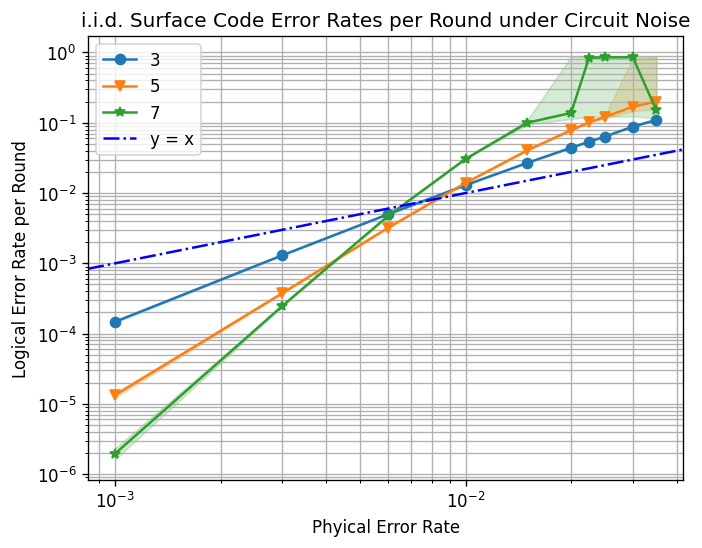

In [33]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.15)
ax.loglog()
ax.set_title("i.i.d. Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [19]:
surface_code_tasks = [
    sinter.Task(
        circuit = create_scaled_circuit_from_t1_t2(
            rounds=d*3,
            distance=d,
            t1t2_mapping=nonuniform_t1t2_dict[d],
            idle_duration_us=0.35,
            target_error_rate=noise,
            ),
        json_metadata={'d': d, 'r': d*3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.001, 0.002, 0.003, 0.004, 0.005, 0.007, 0.009, 0.011, 0.014, 0.017]
]

collected_surface_code_stats_nonuniform_baseline = sinter.collect(
    num_workers=144,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=100_000_000,
    max_errors=5_000_000,
    print_progress=True,
    # save_resume_filepath="inid.checkpoint"
)

Starting 144 workers...
30 tasks left:
  workers    decoder  eta shots_left errors_left json_metadata   
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.001 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.002 
        5 pymatching 403m   99999999     5000000 d=3,r=9,p=0.003 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.004 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.005 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.007 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.009 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.011 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.014 
        5 pymatching    ?  100000000     5000000 d=3,r=9,p=0.017 
        5 pymatching    ?  100000000     5000000 d=5,r=15,p=0.001
        5 pymatching    ?  100000000     5000000 d=5,r=15,p=0.002
        5 pymatching    ?  100000000     5000000 d=5,r=15,p=0.003
        5 pymatching    ?  100000000 

In [20]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats_nonuniform_baseline,
    x_func=lambda stat: stat.json_metadata['p'],
    group_func=lambda stat: stat.json_metadata['d'],
    failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
)

ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# ax.set_ylim(0, 0.1)
# ax.set_xlim(0, 0.15)
ax.loglog()
ax.set_title("i.n.i.d. Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

In [ ]:
# collected_surface_code_stats_nonuniform_rmwpm = sinter.collect(
#     num_workers=144,
#     tasks=surface_code_tasks,
#     decoders=['rmwpm'],
#     custom_decoders={'rmwpm': create_sinter_rmwpm_decoder()},
#     max_shots=100_000_000,
#     max_errors=5_000_000,
#     print_progress=True,
#     # save_resume_filepath="inid_rmwpm.checkpoint"
# )

Starting 144 workers...


In [ ]:
# fig, ax = plt.subplots(1, 1)
# sinter.plot_error_rate(
#     ax=ax,
#     stats=collected_surface_code_stats_nonuniform_rmwpm,
#     x_func=lambda stat: stat.json_metadata['p'],
#     group_func=lambda stat: stat.json_metadata['d'],
#     failure_units_per_shot_func=lambda stat: stat.json_metadata['r'],
# )

# ax.axline((0, 0), slope=1, label='y = x', color='blue', linestyle='-.')
# # ax.set_ylim(0, 0.1)
# # ax.set_xlim(0, 0.15)
# ax.loglog()
# ax.set_title("i.n.i.d. Surface Code Error Rates per Round under Circuit Noise")
# ax.set_xlabel("Phyical Error Rate")
# ax.set_ylabel("Logical Error Rate per Round")
# ax.grid(which='major')
# ax.grid(which='minor')
# ax.legend()
# fig.set_dpi(120)  # Show it bigger

In [34]:
def pseudo_threshold(records_for_one_distance):
    # records: list of (physical_p, logical_per_round), sorted by physical_p
    p_vals = np.array([r['physical'] for r in records_for_one_distance])
    l_vals = np.array([r['logical'] for r in records_for_one_distance])
    diff = l_vals - p_vals

    # exact hit?
    zeros = np.where(np.isclose(diff, 0))[0]
    if len(zeros):
        return p_vals[zeros[0]]

    # find sign change
    signs = np.sign(diff)
    flips = np.where(signs[:-1] * signs[1:] < 0)[0]
    if not len(flips):
        return None  # no intersection inside sampled range

    i = flips[0]
    p1, p2 = p_vals[i], p_vals[i+1]
    d1, d2 = diff[i], diff[i+1]
    # linear interpolation of root between (p1,d1) and (p2,d2)
    return p1 - d1 * (p2 - p1) / (d2 - d1)

def threshold_per_dictance(collected_surface_code_stats):
    records_by_distance = {}
    for stat in collected_surface_code_stats:
        p = stat.json_metadata['p']
        per_shot = stat.errors / stat.shots
        logical = sinter.shot_error_rate_to_piece_error_rate(
        shot_error_rate=per_shot,
        pieces=stat.json_metadata['r'],
    )
    
        records_by_distance.setdefault(stat.json_metadata['d'], []).append({
            'physical': p,
            'logical': logical,
        })
    
    # sort and compute
    thresholds = {}
    for d, recs in records_by_distance.items():
        recs.sort(key=lambda r: r['physical'])
        thresholds[d] = pseudo_threshold(recs)

    return thresholds

In [35]:
uniform_thresholds = threshold_per_dictance(collected_surface_code_stats)
nonuniform_thresholds_baseline = threshold_per_dictance(collected_surface_code_stats_nonuniform_baseline)
# nonuniform_thresholds_rmwpm = threshold_per_dictance(collected_surface_code_stats_nonuniform_rmwpm)

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4.5))

ax.plot(uniform_thresholds.keys(), uniform_thresholds.values(), marker='o', label='i.i.d. uniform (pymatching)')
ax.plot(nonuniform_thresholds_baseline.keys(), nonuniform_thresholds_baseline.values(), marker='s', label='i.ni.d. baseline (pymatching)')
# ax.plot(nonuniform_thresholds_rmwpm.keys(), nonuniform_thresholds_rmwpm.values(), marker='^', label='i.ni.d. rMWPM')
ax.set_xlabel('Code distance')
ax.set_ylabel('Pseudo-threshold probability')
ax.set_title('Pseudo-threshold vs. distance')
ax.set_yscale('log')
ax.grid(which='both', linestyle=':')
ax.legend()
fig.tight_layout()
plt.show()